In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import cupy as np # linear algebra
import cudf as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-data/train.csv
/kaggle/input/house-prices-data/test.csv


# Step 1 : Importing the datasets

In [2]:
traindat=pd.read_csv("/kaggle/input/house-prices-data/train.csv")
y=traindat.iloc[:,-1]
traindat=traindat.iloc[:,:-1]
testdat=pd.read_csv("/kaggle/input/house-prices-data/test.csv")
y=y.astype("float64")


# Step 2: Handling NA Values
- Here first we are checking the counts of NA values in each column

In [3]:
counts=[]
indices=[]
cols=list(traindat.columns)
for i in traindat.columns:
    counts.append(int(np.sum((traindat[i].isna().values))))
for i in range(len(counts)):
    if counts[i]==0:
        indices.append(i)



- Plotting the counts of NA values

<BarContainer object of 80 artists>

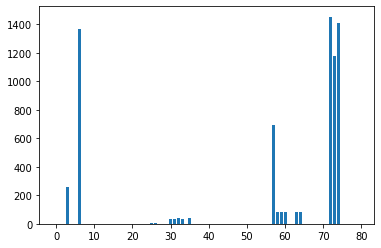

In [4]:
from matplotlib import pyplot as plt
plt.bar(x=range(len(cols)),height=counts)


- Filling NA values with mean

In [5]:
#Handling columns with missing values
for i in traindat.columns[traindat.dtypes=="float64"]:
    traindat[i]=traindat[i].fillna(traindat[i].mean())
for i in testdat.columns[testdat.dtypes=="float64"]:
    testdat=testdat.fillna(testdat[i].mean())
#diff=list(set(traindat).symmetric_difference(set(testdat)))
#for i in diff:
#    if i in traindat.columns:
#        del traindat[i]
#    elif i in testdat.columns:
#        del testdat[i]

- Dropping columns with categorical NA values

In [6]:
#Handling columns with missing values
traindat=traindat.dropna(axis=1)
testdat=testdat.dropna(axis=1)
diff=list(set(traindat).symmetric_difference(set(testdat)))
for i in diff:
    if i in traindat.columns:
        del traindat[i]
    elif i in testdat.columns:
        del testdat[i]

# Step 3 : Label Encoding

In [7]:
onehot=list(traindat.dtypes[traindat.dtypes==object].index)
from cuml.preprocessing import LabelEncoder
x=LabelEncoder()
for i in onehot:
    traindat[i]=x.fit_transform(traindat[i])
onehot=list(testdat.dtypes[testdat.dtypes==object].index)
for i in onehot:
    testdat[i]=x.fit_transform(testdat[i])


In [8]:
conv=traindat.columns[traindat.dtypes=="int64"]
traindat[conv]=traindat[conv].astype("float64")

# Step 4: Plotting the Heatmap 

<AxesSubplot:>

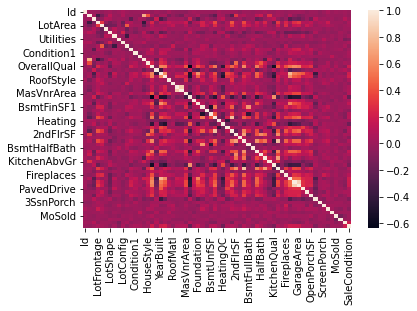

In [9]:
import seaborn as sns
sns.heatmap(traindat.corr().to_pandas())

# Step 5 : Normalization of data with StandardScaler

In [10]:
from cuml.preprocessing import StandardScaler
std=StandardScaler()
traindat_scaled=std.fit_transform(traindat)
testdat_scaled=std.fit_transform(testdat)


In [11]:
traindat_scaled.columns=traindat.columns
testdat_scaled.columns=testdat.columns


# Step 6: Train-Test-Split (Training data=70%)

In [12]:
from cuml.model_selection import train_test_split
X_1, X_2, y_1, y_2 = train_test_split(traindat_scaled, y, test_size=0.3, random_state=42)


- Creating a dataframe to save the results

In [13]:
algorithm = ['svd', 'eig', 'qr', 'svd-qr', 'svd-jacobi']

results=pd.DataFrame(columns=["MAE","R2","MSE"],index=algorithm)

# Step 7: Applying various Linear Regression techniques to find the best fit

In [14]:

from cuml import LinearRegression
import cuml
algorithm = ['svd', 'eig', 'qr', 'svd-qr', 'svd-jacobi']
for i in algorithm:
    lr = LinearRegression(fit_intercept = True, normalize = False, algorithm = i)
    reg = lr.fit(X_1,y_1)
    preds = lr.predict(X_2)
    results.loc[i,"MSE"]=np.array(cuml.metrics.regression.mean_squared_error(y_2,preds)).reshape(1,1)
    
    results.loc[i,"R2"]=np.array(cuml.metrics.regression.r2_score(y_2,preds)).reshape(1,1)
    
    results.loc[i,"MAE"]=np.array(cuml.metrics.regression.mean_absolute_error(y_2,preds)).reshape(1,1)

In [15]:
conv=testdat.columns[testdat.dtypes=="int64"]
testdat[conv]=testdat[conv].astype("float64")

# The results of comparison of different techniques are:

In [16]:
results

,MAE,R2,MSE
svd,20155.49754,0.833914866,981428127.7
eig,20155.49754,0.833914866,981428127.7
qr,20022.36629,0.834364967,978768395.2
svd-qr,6.355299884e+16,-1.325672168e+24,7.833644836e+33
svd-jacobi,6.355299884e+16,-1.325672168e+24,7.833644836e+33


# Fitting best model on test data to generate output and save it

In [17]:
model=LinearRegression(fit_intercept = True, normalize = False, algorithm = "svd")
model.fit(traindat_scaled,y)
res=model.predict(testdat_scaled)

In [18]:
res1=pd.DataFrame(columns=["Id","SalePrice"])

In [19]:
res1["Id"]=testdat["Id"]
res1["SalePrice"]=res

In [20]:
res1["Id"]=res1["Id"].astype("int64")

In [21]:
res1.to_csv("101917042.csv",index=None)